In [1]:
import pandas as pd
from dotenv import load_dotenv
import os

In [2]:
cd ..

/Users/alexwarfel/Documents/fair_value/fair_value


In [3]:
from utils.capture_multiple_fred_series import capture_multiple_fred_series
from utils.extract_data_from_alphavantage import extract_sector_etf_data_from_alphavantage

In [4]:
load_dotenv()  # take environment variables from .env.
fred_api_key = os.getenv('fred_api_key')

In [5]:
combined_data = capture_multiple_fred_series(['FEDFUNDS'],fred_api_key)

In [6]:
# drop records for which all values are NaN
combined_data.dropna(how='all',inplace=True)

In [7]:
extract_sector_etf_data_from_alphavantage()

<Axes: xlabel='date'>

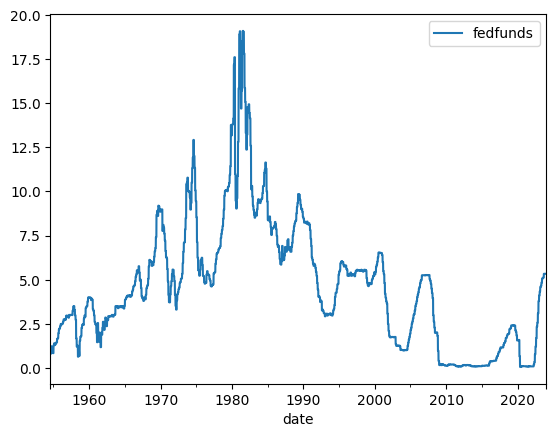

In [8]:
combined_data.plot()

In [9]:
sector_etfs = pd.read_csv(os.path.join('data','sector_etfs.csv'),index_col=0,parse_dates=True)
sector_etfs = sector_etfs.rename(columns=str.lower)
sector_etfs.index = pd.to_datetime(sector_etfs.index)
sector_etfs = sector_etfs[['close','volume','ticker']]
sector_etfs

,close,volume,ticker
timestamp,,,
2018-06-19,49.96,16588.0,XLC
2018-06-20,50.58,189989.0,XLC
2018-06-21,50.27,428740.0,XLC
2018-06-22,50.49,181638.0,XLC
2018-06-23,50.49,181638.0,XLC
...,...,...,...
2024-01-14,476.68,58026420.0,SPY
2024-01-15,476.68,58026420.0,SPY
2024-01-16,474.93,85014870.0,SPY


In [10]:
min_max_index = sector_etfs.copy()
min_max_index['index'] = min_max_index.index
min_max_index = min_max_index.groupby('ticker')['index'].agg(['min', 'max'])
min_max_index.columns = ['min_index', 'max_index']
min_max_index

,min_index,max_index
ticker,,
SPY,1999-11-01,2024-01-18
XLB,1999-11-01,2024-01-18
XLC,2018-06-19,2024-01-18
XLE,1999-11-01,2024-01-18
XLF,1999-11-01,2024-01-18
XLI,1999-11-01,2024-01-18
XLK,1999-11-01,2024-01-18
XLP,1999-11-01,2024-01-18
XLRE,2015-10-08,2024-01-18


Since XLRE and XLC don't have enough history, I'm going to omit them from this analysis. Perhaps they can be added back in later. 

In [11]:
sector_etfs = sector_etfs[~sector_etfs['ticker'].isin(['XLC', 'XLRE'])]
sector_etfs

,close,volume,ticker
timestamp,,,
1999-11-01,28.19,12700.0,XLY
1999-11-02,27.98,3300.0,XLY
1999-11-03,27.75,3100.0,XLY
1999-11-04,28.09,18600.0,XLY
1999-11-05,28.28,7000.0,XLY
...,...,...,...
2024-01-14,476.68,58026420.0,SPY
2024-01-15,476.68,58026420.0,SPY
2024-01-16,474.93,85014870.0,SPY


In [12]:
hlw_estimates = pd.read_csv(os.path.join('data','r_star.csv'),index_col=0,parse_dates=True)
# lowercase all columns, and replace spaces, parentheses, commas, and asterisks with underscores
hlw_estimates.columns = [col.lower().replace(' ','_').replace('(','').replace(')','').replace(',','').replace('*','') for col in hlw_estimates.columns]
hlw_estimates

FileNotFoundError: [Errno 2] No such file or directory: 'data/r_star.csv'

In [ ]:
# join the hlw_estimates to the combined_data dataframe on the date index
combined_data = combined_data.join(hlw_estimates,how='left')
combined_data

In [ ]:
# remove all rows that have NaN values
combined_data.dropna(inplace=True)
combined_data['economic_throttle'] = combined_data['fedfunds'] - combined_data['us_natural_rate_r']
combined_data.to_csv(os.path.join('data','economic_throttle_data.csv'))
combined_data

In [ ]:
combined_data.plot(y='economic_throttle')

In [ ]:
economic_throttle_data = combined_data['economic_throttle']

number_of_months = int(((12*2.1)/4))

fed_funds_rate_rolling_max = economic_throttle_data.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_reversed = economic_throttle_data.iloc[::-1]
fed_funds_rate_rolling_max_forward_reversed = fed_funds_rate_reversed.rolling(number_of_months, min_periods=1).max()

fed_funds_rate_rolling_max_forward = fed_funds_rate_rolling_max_forward_reversed.iloc[::-1]

fed_funds_rate_peaks = economic_throttle_data[(economic_throttle_data == fed_funds_rate_rolling_max) & (economic_throttle_data == fed_funds_rate_rolling_max_forward)]
fed_funds_rate_peaks

In [ ]:
fed_funds_rate_peaks = pd.DataFrame(fed_funds_rate_peaks)
fed_funds_rate_peaks.columns = ['peaks']
fed_funds_rate_peaks['peaks'] = fed_funds_rate_peaks['peaks'].astype('float64')

fed_funds_rate_peaks = fed_funds_rate_peaks[fed_funds_rate_peaks['peaks'].notnull()]
fed_funds_rate_peaks

In [ ]:
mask = pd.Series([False] * len(fed_funds_rate_peaks), index=fed_funds_rate_peaks.index)

for i in range(len(fed_funds_rate_peaks)):
    if i == 0 or fed_funds_rate_peaks['peaks'].iloc[i] != fed_funds_rate_peaks['peaks'].iloc[i-1]:
        mask.iloc[i] = True

result_df = fed_funds_rate_peaks[mask]

result_df

In [ ]:
sector_etfs.loc[(sector_etfs.index >= '2013-12-29') & (sector_etfs.index <= '2014-01-05')]


In [ ]:
# make sure the sector_etfs and result_df indexes are both datetime objects
sector_etfs.index = pd.to_datetime(sector_etfs.index)
result_df.index = pd.to_datetime(result_df.index)

combined_etf_and_economic_data = sector_etfs.merge(result_df,how='left',left_index=True,right_index=True)
combined_etf_and_economic_data.dropna(subset=['peaks'], inplace=True)
combined_etf_and_economic_data.reset_index(inplace=True)
combined_etf_and_economic_data

In [ ]:
sector_etfs.reset_index(inplace=True)
sector_etfs['timestamp'] = pd.to_datetime(sector_etfs['timestamp'])
sector_etfs

In [ ]:
economic_data_timestamps = combined_etf_and_economic_data[['timestamp','ticker']].drop_duplicates().values.tolist()

In [ ]:
unioned_data = pd.DataFrame()

# loop through each combination of timestamp and ticker in the economic_data_timestamps list
for timestamp, ticker in economic_data_timestamps:
    # convert timestamp to datetime object
    timestamp = pd.to_datetime(timestamp)
    # create a dataframe of the timestamp and ticker combination saving the next 365 days of ticker data for each respective ticker
    sector_etf_data = sector_etfs.loc[(sector_etfs['timestamp'] >= timestamp) & (sector_etfs['timestamp'] <= timestamp + pd.Timedelta(days=(365*2))) & (sector_etfs['ticker'] == ticker)].copy()

    sector_etf_data.rename(columns={'timestamp':'future_timestamp','close':'future_close','volume':'future_volume','ticker':'ticker_for_join'},inplace=True)
    sector_etf_data['timestamp_for_join'] = timestamp

    # add the sector_etf_data dataframe to the unioned_data dataframe without using append
    unioned_data = pd.concat([unioned_data,sector_etf_data],axis=0,ignore_index=True)

unioned_data

In [ ]:
total_combined_data = combined_etf_and_economic_data.merge(unioned_data,how='left',left_on=['timestamp','ticker'],right_on=['timestamp_for_join','ticker_for_join'])
total_combined_data['cumulative_return'] = total_combined_data['future_close'] / total_combined_data['close'] - 1
total_combined_data['rownumber'] = total_combined_data.groupby(['timestamp','ticker']).cumcount() + 1
total_combined_data

In [ ]:
total_combined_data.to_csv(os.path.join('data','total_combined_data.csv'),index=False)

In [ ]:
filtered_total_combined_data = total_combined_data.loc[total_combined_data['timestamp'] == pd.to_datetime('2001-01-01')]
filtered_total_combined_data

In [ ]:
# average the cumulative_return partitioned by ticker and rownumber
averaged_total_combined_data = total_combined_data.groupby(['ticker','rownumber']).agg({'cumulative_return':['mean','count']}).reset_index()

# collapse the multi-index columns into a single index by joining the column names with an underscore IF the column is a multi index
averaged_total_combined_data.columns = ['_'.join(col) if col[1]!='' else col[0] for col in averaged_total_combined_data.columns.values]

averaged_total_combined_data


In [ ]:
# plot the cumulative_return by rownumber and ticker
averaged_total_combined_data.pivot(index='rownumber',columns='ticker',values='cumulative_return_mean').plot()

In [ ]:
# pivot the averaged_total_combined_data such that each ticker is a column and the cumulative return is the value
averaged_total_combined_data_pivoted = averaged_total_combined_data.pivot(index='rownumber',columns='ticker',values='cumulative_return_mean')
# rename the rownumber column to "Days since peak restrictive monetary policy"
averaged_total_combined_data_pivoted.index.name = 'Days since peak restrictive monetary policy'

# multiple all values by 100, and round to the second decimal place
averaged_total_combined_data_pivoted = averaged_total_combined_data_pivoted * 100
averaged_total_combined_data_pivoted = averaged_total_combined_data_pivoted.round(2)

# create a dictionary of the tickers and the sector names
ticker_sector_dict = {'XLY':'Consumer discretionary','XLP':'Consumer staples','XLE':'Energy','XLF':'Financials','XLV':'Health care','XLI':'Industrials','XLB':'Materials','XLK':'Technology','XLU':'Utilities','SPY':'S&P 500'}

# rename the columns of the averaged_total_combined_data_pivoted dataframe using the ticker_sector_dict
averaged_total_combined_data_pivoted.columns = [ticker_sector_dict[col] for col in averaged_total_combined_data_pivoted.columns]

averaged_total_combined_data_pivoted.to_csv(os.path.join('data','averaged_total_combined_data_pivoted.csv'))